In [3]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Add, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [6]:
DATASET_PATH = 'audio/'
metadata = pd.read_csv('meta/esc50.csv')


In [7]:
from tensorflow.keras.regularizers import l2

In [9]:

# Function to extract log-Mel spectrogram
def extract_log_mel_spectrogram(signal, sr=22050):
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128, fmax=8000)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

# Normalize log-mel spectrogram between 0 and 1
def normalize_spectrogram(log_mel_spectrogram):
    return (log_mel_spectrogram - np.min(log_mel_spectrogram)) / (np.max(log_mel_spectrogram) - np.min(log_mel_spectrogram))

# Calculate sound intensity in dB
def calculate_sound_intensity(signal):
    intensity = 10 * np.log10(np.mean(signal**2) + 1e-10)  # Add small value to avoid log(0)
    return intensity

# Estimate distance from intensity (Assuming reference intensity I_0 = 10^-12 W/m²)
def estimate_distance(intensity_db):
    I_0 = 1e-12  # Reference intensity
    intensity_linear = 10 ** (intensity_db / 10)  # Convert dB to linear scale
    distance = np.sqrt(I_0 / intensity_linear)  # Inverse square law
    return distance

# Plot spectrogram
def plot_spectrogram(signal, sr=22050):
    plt.figure(figsize=(10, 5))
    log_mel = extract_log_mel_spectrogram(signal, sr)
    librosa.display.specshow(log_mel, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.title('Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Augment audio data with pitch shifting and time-stretching
def augment_audio(signal, sr):
    # Time-stretching
    stretched_signal = librosa.effects.time_stretch(signal, rate=0.8)

    # Pitch-shifting
    pitched_signal = librosa.effects.pitch_shift(signal, sr=sr, n_steps=2)

    return stretched_signal, pitched_signal

# Function to pad or trim the log-mel spectrogram to a fixed length
def pad_or_trim(log_mel_spectrogram, target_length=216):
    if log_mel_spectrogram.shape[1] > target_length:
        return log_mel_spectrogram[:, :target_length]  # Trim to the target length
    else:
        padding = target_length - log_mel_spectrogram.shape[1]
        return np.pad(log_mel_spectrogram, ((0, 0), (0, padding)), mode='constant')

# Extract features
def extract_features(metadata, dataset_path, target_length=216):
    log_mel_features = []
    labels = []
    filenames = []  # To store filenames
    intensities = []  # To store sound intensity
    distances = []  # To store distance estimates
    feature_means = []  # To store mean of log-Mel features

    for index, row in metadata.iterrows():
        file_path = os.path.join(dataset_path, row['filename'])

        if os.path.exists(file_path):
            # Load the audio file
            signal, sr = librosa.load(file_path, sr=22050)

            # Original log-mel spectrogram
            log_mel = extract_log_mel_spectrogram(signal, sr)
            log_mel_normalized = normalize_spectrogram(log_mel)
            log_mel_padded = pad_or_trim(log_mel_normalized, target_length)
            log_mel_features.append(log_mel_padded)
            labels.append(row['category'])
            filenames.append(row['filename'])  # Store the filename

            # Calculate sound intensity and estimate distance
            intensity_db = calculate_sound_intensity(signal)
            distance = estimate_distance(intensity_db)
            intensities.append(intensity_db)
            distances.append(distance)

            # Calculate mean of log-Mel features
            feature_mean = np.mean(log_mel)
            feature_means.append(feature_mean)

            # Augmented data
            stretched_signal, pitched_signal = augment_audio(signal, sr)
            log_mel_stretched = extract_log_mel_spectrogram(stretched_signal, sr)
            log_mel_pitched = extract_log_mel_spectrogram(pitched_signal, sr)

            # Append normalized augmented features
            log_mel_features.append(pad_or_trim(normalize_spectrogram(log_mel_stretched), target_length))
            log_mel_features.append(pad_or_trim(normalize_spectrogram(log_mel_pitched), target_length))

            # Duplicate the labels for augmented data
            labels.append(row['category'])
            labels.append(row['category'])

            # Duplicate filenames for augmented data
            filenames.append(row['filename'])
            filenames.append(row['filename'])

            # For augmented data, we reuse intensity and distance
            intensities.append(intensity_db)
            distances.append(distance)
            intensities.append(intensity_db)
            distances.append(distance)

            # Append mean features for augmented data
            feature_means.append(np.mean(log_mel_stretched))
            feature_means.append(np.mean(log_mel_pitched))

    return np.array(log_mel_features), np.array(labels), np.array(filenames), np.array(intensities), np.array(distances), np.array(feature_means)

# Encode labels and split dataset
def prepare_data(X, y):
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

    # Reshape for CNN (assuming log-mel spectrograms have shape (128, T))
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)

    return X_train, X_val, y_train, y_val, label_encoder

# Function to build a more complex architecture with residual connections
def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), use_batch_norm=True):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same', strides=strides, kernel_regularizer=l2(0.001))(x)

    if use_batch_norm:
        x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding='same', strides=strides, kernel_regularizer=l2(0.001))(x)

    if use_batch_norm:
        x = BatchNormalization()(x)

    # Add the input (shortcut) to the output to create the residual connection
    x = Add()([x, shortcut])
    return x

# Function to create the complex CNN model with residual blocks
def build_complex_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial Conv Block
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # First residual block
    x = residual_block(x, filters=32)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Second residual block
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = residual_block(x, filters=64)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Third residual block
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = residual_block(x, filters=128)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Main code execution
X, y, filenames, intensities, distances, feature_means = extract_features(metadata, DATASET_PATH)

# Prepare data
X_train, X_val, y_train, y_val, label_encoder = prepare_data(X, y)

# Build the model
num_classes = len(label_encoder.classes_)
input_shape = X_train.shape[1:]  # Shape of the spectrogram (128, T, 1)
model = build_complex_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')  # Change to .keras
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, monitor='val_loss')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=50, batch_size=16, callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')


Epoch 1/50
300/300 [==============================] - 124s 398ms/step - loss: 4.1429 - accuracy: 0.1000 - val_loss: 7.0626 - val_accuracy: 0.0375 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - 116s 385ms/step - loss: 3.2592 - accuracy: 0.2152 - val_loss: 4.0466 - val_accuracy: 0.1408 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - 117s 391ms/step - loss: 2.8121 - accuracy: 0.3083 - val_loss: 2.5657 - val_accuracy: 0.3583 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - 119s 395ms/step - loss: 2.4918 - accuracy: 0.3802 - val_loss: 2.9705 - val_accuracy: 0.3242 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - 119s 398ms/step - loss: 2.2049 - accuracy: 0.4558 - val_loss: 2.6466 - val_accuracy: 0.3642 - lr: 0.0010
Epoch 6/50
300/300 [==============================] - 119s 397ms/step - loss: 2.0384 - accuracy: 0.5035 - val_loss: 2.2990 - val_accuracy: 0.4475 - lr: 0.0010
Epoch 7/50
300/300 [==========================

In [1]:
print(metadata.head())

# Optionally plot the training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')              
plt.legend()
plt.show()

NameError: name 'metadata' is not defined

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load the saved model
model = load_model('best_model.keras')

# Load the metadata CSV file (ESC-50)
metadata = pd.read_csv('meta/esc50.csv')

# Function to extract log-Mel spectrogram (same as before)
def extract_log_mel_spectrogram(signal, sr=22050):
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128, fmax=8000)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

# Function to normalize the spectrogram
def normalize_spectrogram(log_mel_spectrogram):
    return (log_mel_spectrogram - np.min(log_mel_spectrogram)) / (np.max(log_mel_spectrogram) - np.min(log_mel_spectrogram))

# Function to pad or trim the spectrogram to a fixed length
def pad_or_trim(log_mel_spectrogram, target_length=216):
    if log_mel_spectrogram.shape[1] > target_length:
        return log_mel_spectrogram[:, :target_length]  # Trim
    else:
        padding = target_length - log_mel_spectrogram.shape[1]
        return np.pad(log_mel_spectrogram, ((0, 0), (0, padding)), mode='constant')

# Calculate sound intensity in dB
def calculate_sound_intensity(signal):
    intensity = 10 * np.log10(np.mean(signal**2) + 1e-10)  # Add small value to avoid log(0)
    return intensity

# Estimate distance from intensity
def estimate_distance(intensity_db):
    I_0 = 1e-12  # Reference intensity
    intensity_linear = 10 ** (intensity_db / 10)  # Convert dB to linear scale
    distance = np.sqrt(I_0 / intensity_linear)  # Inverse square law
    return distance

# Process and predict on new data
log_mel_features = []
filenames = []
intensities = []
distances = []
true_labels = []
predicted_labels = []

# Label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(metadata['category'])  # Assuming 'category' is the label column
label_map = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

# Iterate over each audio file
for index, row in metadata.iterrows():
    file_path = os.path.join('audio', row['filename'])

    if os.path.exists(file_path):
        # Load the audio file
        signal, sr = librosa.load(file_path, sr=22050)

        # Extract and preprocess features
        log_mel = extract_log_mel_spectrogram(signal, sr)
        log_mel_normalized = normalize_spectrogram(log_mel)
        log_mel_padded = pad_or_trim(log_mel_normalized)

        # Add batch dimension for prediction
        log_mel_padded = np.expand_dims(log_mel_padded, axis=-1)  # Add channel dimension
        log_mel_padded = np.expand_dims(log_mel_padded, axis=0)   # Add batch dimension

        # Predict class
        prediction = model.predict(log_mel_padded)
        predicted_class = np.argmax(prediction)
        predicted_label = label_map[predicted_class]

        # Calculate sound intensity and estimate distance
        intensity_db = calculate_sound_intensity(signal)
        distance = estimate_distance(intensity_db)

        # Append results to lists
        filenames.append(row['filename'])
        true_labels.append(row['category'])
        predicted_labels.append(predicted_label)
        intensities.append(intensity_db)
        distances.append(distance)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Filename': filenames,
    'True Classification': true_labels,
    'Predicted Classification': predicted_labels,
    'Sound Intensity (dB)': intensities,
    'Estimated Distance (m)': distances
})

# Save results to CSV
results_df.to_csv('predictions_with_intensity_distance.csv', index=False)

# Show the first few rows of the DataFrame
print(results_df.head())


1/1 [==============================] - 0s 65ms/step
            Filename True Classification Predicted Classification  \
0   1-100032-A-0.wav                 dog                      dog   
1  1-100038-A-14.wav      chirping_birds           chirping_birds   
2  1-100210-A-36.wav      vacuum_cleaner           vacuum_cleaner   
3  1-100210-B-36.wav      vacuum_cleaner           vacuum_cleaner   
4  1-101296-A-19.wav        thunderstorm             thunderstorm   

   Sound Intensity (dB)  Estimated Distance (m)  
0            -27.634532                0.000024  
1            -24.239723                0.000016  
2            -11.221001                0.000004  
3            -10.982516                0.000004  
4            -39.215927                0.000091  


In [9]:
import pandas as pd

# Load the predictions CSV file
predictions = pd.read_csv('predictions_with_intensity_distance.csv')

# Define category mappings including thunderstorm and brushing_teeth
category_mapping = {
    'dog': 'Animals',
    'rooster': 'Animals',
    'pig': 'Animals',
    'cow': 'Animals',
    'frog': 'Animals',
    'cat': 'Animals',
    'hen': 'Animals',
    'insects': 'Animals',
    'sheep': 'Animals',
    'crow': 'Animals',
    'rain': 'Natural soundscapes & water sounds',
    'sea_waves': 'Natural soundscapes & water sounds',
    'crackling_fire': 'Natural soundscapes & water sounds',
    'crickets': 'Natural soundscapes & water sounds',
    'chirping_birds': 'Natural soundscapes & water sounds',
    'water_drops': 'Natural soundscapes & water sounds',
    'wind': 'Natural soundscapes & water sounds',
    'pouring_water': 'Natural soundscapes & water sounds',
    'thunderstorm': 'Natural soundscapes & water sounds',  # Added
    'toilet_flush': 'Interior/domestic sounds',
    'door_wood_knock': 'Interior/domestic sounds',
    'mouse_click': 'Interior/domestic sounds',
    'keyboard_typing': 'Interior/domestic sounds',
    'door_wood_creaks': 'Interior/domestic sounds',
    'can_opening': 'Interior/domestic sounds',
    'washing_machine': 'Interior/domestic sounds',
    'vacuum_cleaner': 'Interior/domestic sounds',
    'clock_alarm': 'Interior/domestic sounds',
    'clock_tick': 'Interior/domestic sounds',
    'glass_breaking': 'Interior/domestic sounds',
    'helicopter': 'Exterior/urban noises',
    'chainsaw': 'Exterior/urban noises',
    'siren': 'Exterior/urban noises',
    'car_horn': 'Exterior/urban noises',
    'engine': 'Exterior/urban noises',
    'train': 'Exterior/urban noises',
    'church_bells': 'Exterior/urban noises',
    'airplane': 'Exterior/urban noises',
    'fireworks': 'Exterior/urban noises',
    'hand_saw': 'Exterior/urban noises',
    'breathing': 'Human, non-speech sounds',
    'coughing': 'Human, non-speech sounds',
    'footsteps': 'Human, non-speech sounds',
    'laughing': 'Human, non-speech sounds',
    'sneezing': 'Human, non-speech sounds',
    'clapping': 'Human, non-speech sounds',
    'snoring': 'Human, non-speech sounds',
    'drinking_sipping': 'Human, non-speech sounds',
    'brushing_teeth': 'Human, non-speech sounds',  # Added
    'door_slam': 'Human, non-speech sounds',
    'speech': 'Human, non-speech sounds',
    'crying_baby': 'Human, non-speech sounds'
}

# Create a new column 'broad_category' based on the 'Predicted Classification' column
predictions['broad_category'] = predictions['Predicted Classification'].map(category_mapping)

# Save the updated DataFrame to a new CSV file
predictions.to_csv('predictions_with_intensity_distance_updated.csv', index=False)

print("New column with broad categories added to the predictions CSV file.")


New column with broad categories added to the predictions CSV file.


Epoch 1/100
150/150 [==============================] - 127s 822ms/step - loss: 4.2496 - accuracy: 0.0992 - val_loss: 8.3231 - val_accuracy: 0.0183 - lr: 0.0010
Epoch 2/100
150/150 [==============================] - 123s 816ms/step - loss: 3.4047 - accuracy: 0.1881 - val_loss: 7.1519 - val_accuracy: 0.0183 - lr: 0.0010
Epoch 3/100
150/150 [==============================] - 122s 816ms/step - loss: 2.9601 - accuracy: 0.2808 - val_loss: 5.7718 - val_accuracy: 0.0675 - lr: 0.0010
Epoch 4/100
150/150 [==============================] - 121s 805ms/step - loss: 2.6539 - accuracy: 0.3523 - val_loss: 4.1800 - val_accuracy: 0.1842 - lr: 0.0010
Epoch 5/100
150/150 [==============================] - 121s 809ms/step - loss: 2.3979 - accuracy: 0.4119 - val_loss: 2.3723 - val_accuracy: 0.4267 - lr: 0.0010
Epoch 6/100
150/150 [==============================] - 121s 808ms/step - loss: 2.1474 - accuracy: 0.4792 - val_loss: 4.0266 - val_accuracy: 0.2192 - lr: 0.0010
Epoch 7/100
150/150 [===================

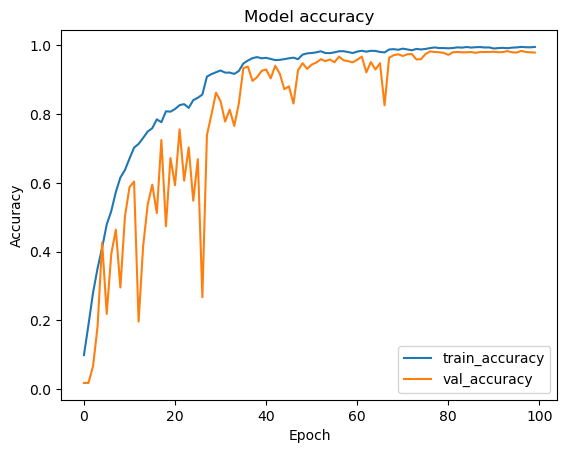

In [13]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2

DATASET_PATH = 'audio/'
metadata = pd.read_csv('meta/esc50.csv')


# Function to remove noise using Wiener filter
def remove_noise(signal):
    return librosa.effects.preemphasis(signal)

# Function to extract log-Mel spectrogram
def extract_log_mel_spectrogram(signal, sr=22050):
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128, fmax=8000)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

# Normalize log-mel spectrogram between 0 and 1
def normalize_spectrogram(log_mel_spectrogram):
    return (log_mel_spectrogram - np.min(log_mel_spectrogram)) / (np.max(log_mel_spectrogram) - np.min(log_mel_spectrogram))

# Calculate sound intensity in dB
def calculate_sound_intensity(signal):
    intensity = 10 * np.log10(np.mean(signal**2) + 1e-10)  # Add small value to avoid log(0)
    return intensity

# Estimate distance from intensity (Assuming reference intensity I_0 = 10^-12 W/m²)
def estimate_distance(intensity_db):
    I_0 = 1e-12  # Reference intensity
    intensity_linear = 10 ** (intensity_db / 10)  # Convert dB to linear scale
    distance = np.sqrt(I_0 / intensity_linear)  # Inverse square law
    return distance

# Plot spectrogram
def plot_spectrogram(signal, sr=22050):
    plt.figure(figsize=(10, 5))
    log_mel = extract_log_mel_spectrogram(signal, sr)
    librosa.display.specshow(log_mel, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.title('Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Augment audio data with pitch shifting and time-stretching
def augment_audio(signal, sr):
    # Time-stretching
    stretched_signal = librosa.effects.time_stretch(signal, rate=0.8)

    # Pitch-shifting
    pitched_signal = librosa.effects.pitch_shift(signal, sr=sr, n_steps=2)

    return stretched_signal, pitched_signal

# Function to pad or trim the log-mel spectrogram to a fixed length
def pad_or_trim(log_mel_spectrogram, target_length=216):
    if log_mel_spectrogram.shape[1] > target_length:
        return log_mel_spectrogram[:, :target_length]  # Trim to the target length
    else:
        padding = target_length - log_mel_spectrogram.shape[1]
        return np.pad(log_mel_spectrogram, ((0, 0), (0, padding)), mode='constant')

# Extract features
def extract_features(metadata, dataset_path, target_length=216):
    log_mel_features = []
    labels = []
    filenames = []  # To store filenames
    intensities = []  # To store sound intensity
    distances = []  # To store distance estimates
    feature_means = []  # To store mean of log-Mel features

    for index, row in metadata.iterrows():
        file_path = os.path.join(dataset_path, row['filename'])

        if os.path.exists(file_path):
            # Load the audio file
            signal, sr = librosa.load(file_path, sr=22050)

            # Remove noise from the audio signal
            signal = remove_noise(signal)

            # Original log-mel spectrogram
            log_mel = extract_log_mel_spectrogram(signal, sr)
            log_mel_normalized = normalize_spectrogram(log_mel)
            log_mel_padded = pad_or_trim(log_mel_normalized, target_length)
            log_mel_features.append(log_mel_padded)
            labels.append(row['category'])
            filenames.append(row['filename'])  # Store the filename

            # Calculate sound intensity and estimate distance
            intensity_db = calculate_sound_intensity(signal)
            distance = estimate_distance(intensity_db)
            intensities.append(intensity_db)
            distances.append(distance)

            # Calculate mean of log-Mel features
            feature_mean = np.mean(log_mel)
            feature_means.append(feature_mean)

            # Augmented data
            stretched_signal, pitched_signal = augment_audio(signal, sr)
            log_mel_stretched = extract_log_mel_spectrogram(stretched_signal, sr)
            log_mel_pitched = extract_log_mel_spectrogram(pitched_signal, sr)

            # Append normalized augmented features
            log_mel_features.append(pad_or_trim(normalize_spectrogram(log_mel_stretched), target_length))
            log_mel_features.append(pad_or_trim(normalize_spectrogram(log_mel_pitched), target_length))

            # Duplicate the labels for augmented data
            labels.append(row['category'])
            labels.append(row['category'])

            # Duplicate filenames for augmented data
            filenames.append(row['filename'])
            filenames.append(row['filename'])

            # For augmented data, we reuse intensity and distance
            intensities.append(intensity_db)
            distances.append(distance)
            intensities.append(intensity_db)
            distances.append(distance)

            # Append mean features for augmented data
            feature_means.append(np.mean(log_mel_stretched))
            feature_means.append(np.mean(log_mel_pitched))

    return np.array(log_mel_features), np.array(labels), np.array(filenames), np.array(intensities), np.array(distances), np.array(feature_means)

# Encode labels and split dataset
def prepare_data(X, y):
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

    # Reshape for CNN (assuming log-mel spectrograms have shape (128, T))
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)

    return X_train, X_val, y_train, y_val, label_encoder

# Function to build a more complex architecture with residual connections
def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), use_batch_norm=True):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same', strides=strides, kernel_regularizer=l2(0.001))(x)

    if use_batch_norm:
        x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding='same', strides=strides, kernel_regularizer=l2(0.001))(x)

    if use_batch_norm:
        x = BatchNormalization()(x)

    # Add the input (shortcut) to the output to create the residual connection
    x = Add()([x, shortcut])
    return x

# Function to create the complex CNN model with residual blocks
def build_complex_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial Conv Block
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # First residual block
    x = residual_block(x, filters=32)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Second residual block
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = residual_block(x, filters=64)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Third residual block
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = residual_block(x, filters=128)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Load your metadata file
import pandas as pd



# Extract features and prepare the dataset
X, y, filenames, intensities, distances, feature_means = extract_features(metadata, DATASET_PATH)

# Prepare data for training
input_shape = (128, 216, 1)  # (Mel bands, Time frames, Channels)
X_train, X_val, y_train, y_val, label_encoder = prepare_data(X, y)

# Build and compile the model
model = build_complex_model(input_shape, num_classes=len(label_encoder.classes_))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, 
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Save the model
model.save('classification_model.h5')

# Optionally plot the training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')              
plt.legend()
plt.show()


In [21]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import scipy.signal as sp_signal  # Import signal processing module

# Load the saved model
model = load_model('classification_model.h5')

# Load the metadata CSV file (ESC-50)
metadata = pd.read_csv('meta/esc50.csv')

# Function to extract log-Mel spectrogram (same as before)
def extract_log_mel_spectrogram(signal_data, sr=22050):
    mel_spectrogram = librosa.feature.melspectrogram(y=signal_data, sr=sr, n_mels=128, fmax=8000)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

# Function to normalize the spectrogram
def normalize_spectrogram(log_mel_spectrogram):
    return (log_mel_spectrogram - np.min(log_mel_spectrogram)) / (np.max(log_mel_spectrogram) - np.min(log_mel_spectrogram))

# Function to pad or trim the spectrogram to a fixed length
def pad_or_trim(log_mel_spectrogram, target_length=216):
    if log_mel_spectrogram.shape[1] > target_length:
        return log_mel_spectrogram[:, :target_length]  # Trim
    else:
        padding = target_length - log_mel_spectrogram.shape[1]
        return np.pad(log_mel_spectrogram, ((0, 0), (0, padding)), mode='constant')

# Noise removal using a high-pass filter
def remove_noise(signal_data, sr=22050, cutoff_freq=1000):
    sos = sp_signal.butter(10, cutoff_freq, 'hp', fs=sr, output='sos')  # Use scipy.signal for butter filter
    filtered_signal = sp_signal.sosfilt(sos, signal_data)
    return filtered_signal

# Calculate sound intensity in dB
def calculate_sound_intensity(signal_data):
    intensity = 10 * np.log10(np.mean(signal_data**2) + 1e-10)  # Add small value to avoid log(0)
    return intensity

# Estimate distance from intensity
def estimate_distance(intensity_db):
    I_0 = 1e-12  # Reference intensity
    intensity_linear = 10 ** (intensity_db / 10)  # Convert dB to linear scale
    distance = np.sqrt(I_0 / intensity_linear)  # Inverse square law
    return distance

# Function to observe if there's a change in noise after applying noise removal
def noise_removal_observed(original_signal, filtered_signal):
    original_intensity = calculate_sound_intensity(original_signal)
    filtered_intensity = calculate_sound_intensity(filtered_signal)
    return filtered_intensity < original_intensity  # True if noise reduced

# Process and predict on new data
log_mel_features = []
filenames = []
intensities = []
distances = []
true_labels = []
predicted_labels = []
noise_removed = []

# Label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(metadata['category'])  # Assuming 'category' is the label column
label_map = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

# Iterate over each audio file
for index, row in metadata.iterrows():
    file_path = os.path.join('audio', row['filename'])

    if os.path.exists(file_path):
        # Load the audio file
        audio_signal, sr = librosa.load(file_path, sr=22050)  # Renamed signal to audio_signal

        # Apply noise removal
        filtered_signal = remove_noise(audio_signal, sr)

        # Extract and preprocess features (log-Mel spectrogram)
        log_mel = extract_log_mel_spectrogram(filtered_signal, sr)
        log_mel_normalized = normalize_spectrogram(log_mel)
        log_mel_padded = pad_or_trim(log_mel_normalized)

        # Add batch dimension for prediction
        log_mel_padded = np.expand_dims(log_mel_padded, axis=-1)  # Add channel dimension
        log_mel_padded = np.expand_dims(log_mel_padded, axis=0)   # Add batch dimension

        # Predict class
        prediction = model.predict(log_mel_padded)
        predicted_class = np.argmax(prediction)
        predicted_label = label_map[predicted_class]

        # Calculate sound intensity and estimate distance
        intensity_db = calculate_sound_intensity(filtered_signal)
        distance = estimate_distance(intensity_db)

        # Observe if noise was reduced after filtering
        noise_change_observed = noise_removal_observed(audio_signal, filtered_signal)

        # Append results to lists
        filenames.append(row['filename'])
        true_labels.append(row['category'])
        predicted_labels.append(predicted_label)
        intensities.append(intensity_db)
        distances.append(distance)
        noise_removed.append(noise_change_observed)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Filename': filenames,
    'True Classification': true_labels,
    'Predicted Classification': predicted_labels,
    'Sound Intensity (dB)': intensities,
    'Estimated Distance (m)': distances,
    'Noise Removed (Change Observed)': noise_removed
})

# Save results to CSV
results_df.to_csv('predictions_with_noise_removal_intensity_distance.csv', index=False)

# Show the first few rows of the DataFrame
print(results_df.head())


1/1 [==============================] - 0s 48ms/step
            Filename True Classification Predicted Classification  \
0   1-100032-A-0.wav                 dog                      dog   
1  1-100038-A-14.wav      chirping_birds           chirping_birds   
2  1-100210-A-36.wav      vacuum_cleaner           vacuum_cleaner   
3  1-100210-B-36.wav      vacuum_cleaner           vacuum_cleaner   
4  1-101296-A-19.wav        thunderstorm              clock_alarm   

   Sound Intensity (dB)  Estimated Distance (m)  \
0            -29.212820                0.000029   
1            -24.358049                0.000017   
2            -12.544397                0.000004   
3            -12.336505                0.000004   
4            -61.611612                0.001204   

   Noise Removed (Change Observed)  
0                             True  
1                             True  
2                             True  
3                             True  
4                             True  
